# Generate K-means Clusters

In [51]:
"""
K-Means Clustering
Purpose: Find clusters and their outliers, output the results to np arrays.

Required:
.pkl file produced from keplerml.py.

This was created with the intent to cluster lightcurves based on the features calculated by keplerml.py. However,
the methodology used is general and can be applied to any set of data as long as the data is saved as a pickle file
with the identifier (file name) as the [:,0] index, and the rest of the data for each file as the [:,1:] 
indices.
"""

import ast
import random
import numpy as np
np.set_printoptions(threshold='nan')
import scipy as sp
from scipy import stats
import pyfits
import math
import matplotlib.pyplot as plt
import heapq
import scipy.signal
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from numpy.random import RandomState
from multiprocessing import Pool
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import RadioButtons
import os
import sys
import cPickle as pickle
if sys.version_info[0] < 3:
    from Tkinter import Tk
else:
    from tkinter import Tk

from tkFileDialog import askopenfilename,askdirectory

# Transposition. Will change an array orgnaized by data point (coordinates) to an array organized 
# by feature (list of all values for each feature) and vice versa.
def reorganizeArray(X):
    return [[X[i][j] for i in range(len(X))] for j in range(len(X[0]))]

def bounding_box(X):
    # X is the data that comes in, it's organized by lightcurve[[all features for lc 1],[features for lc2],...]
    # To find minima we need to consider all points for each feature seperate from the other features.
    Xbyfeature = reorganizeArray(X)

    # xmin/xmax will be an array of the minimum/maximum values of the features
    xmin=[]
    xmax=[]
    # Create the minimum vertex, and the maximum vertex for the box
    for feature in range(60):
        xmin.append(min(Xbyfeature[feature]))
        xmax.append(max(Xbyfeature[feature]))
        
    return (xmin,xmax)

def KMeans_clusters(data,nclusters):
    # Run KMeans, get clusters
    npdata = np.array(data)
    est = KMeans(n_clusters=nclusters)
    est.fit(npdata)
    clusters = est.labels_
    centers = est.cluster_centers_
    return clusters, centers

def seperatedClusters(data,nclusters,clusters):
    """
    Args:
    data - all data, organized by lightcurve 
    nclusters - number of clusters
    clusters - cluster labels
    
    Purpose: Create arrays dataByCluster and clusterIndexes containing data seperated by
    by cluster.
    """
    dataByCluster = []
    clusterIndexes = []
    
    # Will try to stick to the following:
    # cluster i, lightcurve j, feature k
    for i in range(nclusters):
        # Keeping track of which points get pulled into each cluster:
        clusterIndexes.append([j for j in range(len(data)) if clusters[j]==i])
        # Separating the clusters out into their own arrays (w/in the cluster array)
        dataByCluster.append([data[clusterIndexes[i][j]] for j in range(len(clusterIndexes[i]))])
        
    return dataByCluster, clusterIndexes

def distances(pointsForDistance,referencePoint):
    """
    Args:
    cluster/pointsForDistance - array of any number of points, each point an array of it's features
    centerloc/referencePoint - array of the features for a single point
    
    Purpose: 
    This will calculate the distances of a group of points to a given point.
    I should change the reference point to the center of the cluster rather than the point closest to the center.
    
    """
    distFromCenter = [0 for j in range(len(pointsForDistance))] # reinitializing for each cluster
    # loop for each lightcurve of the cluster
    for j in range(len(pointsForDistance)):
        dataloc=pointsForDistance[j] # coordinates of the datapoint
        sqrd=0
        # loop for each feature of the lightcurve 
        for k in range(len(referencePoint)):
            sqrd+=pow(dataloc[k]-referencePoint[k],2) # (x-x0)^2+(y-y0)^2+...
        distance = pow(sqrd,0.5) # sqrt((x-x0)^2+(y-y0)^2+...)
        distFromCenter[j]=distance 
    return distFromCenter

def beyondCutoff(cutoff,distances):
    """
    returns: outliers and typical arrays
        outlier array contains indexes of the specific cluster array that are beyond the cutoff
        typical array contains single index of the cluster array that is nearest the center
    
    Args:
    cutoff - a number, everything beyond this number is considered an outlier
    distances - array containing distances to each lightcurve point from the center for a given cluster
    """
    outliers=[j for j in range(len(distances)) if distances[j]>=cutoff] # recalculated for each cluster
    typical=[j for j in range(len(distances)) if distances[j]==min(distances)]
    return outliers,typical

def outliers(data,clusters,centers,files):
    """
    Args:
    data - all the data
    clusters - the cluster labels from kmeans. DBSCAN will require different methodology
    centers - locations of the cluster centers
    
    Purpose:
    Separate out the data on the edge of the clusters which are the most likely anomalous data.
    
    """
    
    nclusters = len(centers)

    # Sanity check, if this isn't an outlier than something is wrong.
    """
    controlPoint = np.array([10000 for i in range(len(data[0]))])
    
    data=np.append(data,[controlPoint],axis=0)
    clusters=np.append(clusters,[1],axis=0)
    """
    
    """
    Initializing arrays
    """
    
    cluster, clusterIndexes = seperatedClusters(data,nclusters,clusters)
    clusterIndexes = np.array(clusterIndexes)
    twoSigma = [] #probably doesn't need an array 
    distFromCenter = []
    allTypical=[]
    allOutliers=[]
    # Will try to stick to the following:
    # cluster i, lightcurve j, feature k
    for i in range(nclusters):
                
        """
        ========== Checking density of clusters ============
        Given that some of the clusters may have 0 spread in a given feature, I'm not confident that this is meaningful,
        but there's a chance this can give insight into potentially outlying clusters (clusters of misfits)
        """
        (xmin,xmax)=bounding_box(cluster[i]) # get the minimum and maximum values for both
        
        diff=[xmax[n]-xmin[n] for n in range(len(xmin))]
        volOfClusterBB=1.0
        for n in diff:
            if n!=0:
                volOfClusterBB*=n
        densOfCluster=len(cluster[i])/volOfClusterBB
        """
        print("Cluster: %s, Density: %s" %(i,densOfCluster))
        print volOfClusterBB
        """
        
        """
        ========== Finding points outside of the cutoff ===========
        """
        # not currently using this cutoff.
        twoSigma.append(2*np.std(cluster[i]))
        
        """
            ==== Calculating distances to each point ====
        """
        # Calculate distances to each point in each cluster to the center of its cluster
        distFromCenter.append(distances(cluster[i],centers[i]))
        
        """
            ==== Finding outliers and the standard (defined by the closest to the center) ====
        """
        cutoff=.5*max(distFromCenter[i])
        # Will implement a better cutoff.
        
        # returns cluster indices of the outliers and the typical lcs
        outliers,typical = beyondCutoff(cutoff,distFromCenter[i])
        
        # Add typical lightcurve to list. Only 1 produced at present, but this may change. The following
        # accounts for adding more typicals later.
        clusterIndexes[i] = np.array(clusterIndexes[i])
        allTypical.append(clusterIndexes[i][typical])
            
        # place outliers from this cluster into general outlier list
        allOutliers.append(clusterIndexes[i][outliers])
        
    return allOutliers,allTypical

"""
============ Start ============
"""
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
output = askopenfilename() # locate the pickle file with the relevant data

if output:
    
    pathtofile = os.path.dirname(output)
    outputfile = open(output,'r+') # show an "Open" dialog box and return the path to the selected file
    outputdata = []
    while True:
        try:
            o = pickle.load(outputfile)
        except EOFError:
            break
        else:
            outputdata.append(o)
    outputfile.close()
    

    files = [outputdata[i][0] for i in range(len(outputdata)) if not np.isnan(outputdata[i][1:]).any() and not np.isinf(outputdata[i][1:]).any()]
    data = np.array([outputdata[i][1:] for i in range(len(outputdata)) if not np.isnan(outputdata[i][1:]).any() and not np.isinf(outputdata[i][1:]).any()])
    
    # files with NaN will automatically be classified as outliers
    filesNaN = [outputdata[i][0] for i in range(len(outputdata)) if np.isnan(outputdata[i][1:]).any() or np.isinf(outputdata[i][1:]).any()]
    dataNaN = np.array([outputdata[i][1:] for i in range(len(outputdata)) if np.isnan(outputdata[i][1:]).any() or np.isinf(outputdata[i][1:]).any()])
    # nclusters can be obtained through the optimalK.py script 
    nclusters = int(raw_input('Enter the number of clusters expected: '))

    clusterLabels,centers=KMeans_clusters(data,nclusters)
    dataByCluster,clusterIndexes = seperatedClusters(data,nclusters,clusterLabels)
    outliers,typical=outliers(data,clusterLabels,centers,files)
    
    """
    Saving all cluster output in a single pickle file.
    format: [filename array,cluster label array,data array array]
    """
    clusterLabels = clusterLabels+1
    for i in typical:
        clusterLabels[i] = 0
    nclusters = max(clusterLabels)
    for i in outliers:
        clusterLabels[i] = nclusters+1
    for i in range(len(filesNaN)):
        files.append(filesNaN[i])
        data = np.append(data,dataNaN[i])
        clusterLabels = np.append(clusterLabels,nclusters+1)

    clusteroutputarray = [files,clusterLabels,data]
    clusteroutput = pathtofile+'/'+raw_input('Save as: ')+'.pkl'
    # Tests to see if output has been created previously. Allows the user to replace the existing cluster data or abort.
    if os.path.isfile(clusteroutput):
        while os.path.isfile(clusteroutput):
            replace = raw_input('Cluster output file exists, replace? (y/n) ')
            if replace == 'y':
                break
            elif replace == 'n':
                clusteroutput = pathtofile+'/'+raw_input('Enter new file name: ')+'.pkl'
            else:
                while(replace!=('y' or 'n')):
                    replace = raw_input("Invalid response (y/n): ")
    else:
        open(clusteroutput,'a').close()
    clusterfile = open(clusteroutput,'r+')
    pickle.dump(clusteroutputarray,clusterfile)
    clusterfile.close()
    print("Done.")

Enter the number of clusters expected: 6
Save as: Q4_00_Clusters
Done.


# Import (kmeans) or generate (DBSCAN) clusters

In [68]:
""" 
This will plot individual clusters into a 3D scatter and on choosing (clicking on) a point, 
plot the point's associated lightcurve. The 3 axes will be selectable via radiobuttons.

This may be applied to any scatter of data with associated lightcurves (assuming the 
lightcurve data is available and the filelist appropriately named).

TODO: Make this general, plot DBSCAN or KMeans generated clusters.
Want to plot uniquely for Kmeans and DBSCAN

Requirements:
Filelist - Containing file names of the lightcurve data for the cluster
Data file - numpy array containing calculated features for each lightcurve
Optional:
Outlier filelist - contains the file names for the outliers and the typical* lightcurve. 
    The typical lightcurve must be on line number 1.

*typical as defined by closest to the center of the cluster


Example file list:
    Name: exfilelist
    Content:
    lightcurve1_llc.fits
    lightcurve2_llc.fits
    lightcurve3_llc.fits

Note: There can be no blank lines in the filelist.

Example numpy file:
    Name: exdataByLightCurve.npy
    Content (when read-in by np.load()):
    [[data for lightcurve1]
     [data for lightcurve2]
     [data for lightcurve3]]
 
Note: The filelist and the .npy must have the above fromat and must be organized in the same way,
e.g. the first index of the array corresponds to the first line of the filelist.

filelist: identifier+'filelist'    npy: identifier+'dataByLighCurve.npy'
In the example above the identifier was 'ex'.
"""
import ast
import random
import numpy as np
np.set_printoptions(threshold='nan')
import scipy as sp
from scipy import stats
import pyfits
import math
from sklearn.cluster import DBSCAN
# The order of the following is important, matplot.use('TkAgg') must be done before importing pyplot
import matplotlib
from mpl_toolkits.mplot3d import Axes3D,proj3d
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from multiprocessing import Pool,cpu_count
import sys
import os
import cPickle as pickle
from numbapro import cuda
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
from tkFileDialog import askopenfilename,askdirectory

root = Tk.Tk()
root.wm_title("Scatter")

def reorganizeArray(X): 
    # This is just a transposition, could be accomplished by making X an np.array then transposing via X.T if prefered
    # TODO: Time the difference with large datasets (100,000+)
    return [[X[i][j] for i in range(len(X))] for j in range(len(X[0]))]

def DBSCAN_clusters(data,eps,min_points=None):
    npdata = np.array(data)
    if min_points==None:
        est = DBSCAN(eps=eps)
    else:
        est = DBSCAN(eps=eps,min_samples=min_points)
    
    est.fit(npdata)
    clusters = est.labels_
    coreSampleIndices = est.core_sample_indices_
    return clusters, coreSampleIndices

@cuda.autojit
def clusterIndsCuda(clusterLabels,clusterIndices):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    i = tx + bx * bw
    if i<=len(clusterLabels):
        if clusterLabels[i]!=0 and clusterLabels[i]<outs:
            clusterIndices[i]=int(i)
        else:
            clusterIndices[i]=N+1
            return 
@cuda.autojit
def centerIndsCuda(clusterLabels,clusterIndices):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    i = tx + bx * bw
    if i<=len(clusterLabels):
        if clusterLabels[i]==0:
            clusterIndices[i]=int(i)
        else:
            clusterIndices[i]=N+1
            return 
@cuda.autojit
def outlierIndsCuda(clusterLabels,clusterIndices):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    i = tx + bx * bw
    if i<=len(clusterLabels):
        if clusterLabels[i]==outs:
            clusterIndices[i]=int(i)
        else:
            clusterIndices[i]=N+1
            return 
        
"""--- Importing the relevant data ---"""
clusterType = raw_input('Which clustering method (kmeans or dbscan)? ')
if clusterType == 'KMeans' or clusterType == 'kmeans' or clusterType == 'Kmeans': 
    Tk.Tk.withdraw(root)
    print("Choose the directory the cluster data is contained in.")
    pathtofile = askopenfilename() # Choose the cluster file
    openclusterfile = open(pathtofile,'r+')
    print("Importing pickle file...")
    clusterfile = pickle.load(openclusterfile)
    print("File imported")
    openclusterfile.close()
    files = np.array(clusterfile[0])
    clusterLabels = np.array(clusterfile[1])
    data = np.array(clusterfile[2])
    
    clusterIndices = []
    outlierIndices = []
    centerIndices = []
    print("Seperating into clusters, outliers, and centers...")
    
    ### Start Cuda GPU Stuff ###
    outs=max(clusterLabels)
    N=len(clusterLabels)
    # Send clusterLabels to gpu
    d_clusterLabels = cuda.to_device(clusterLabels)
    # Create array for cluster indexes
    clusterIndices = np.empty(N)
    d_clusterIndices=cuda.to_device(clusterIndices)
    d_centerIndices=cuda.to_device(clusterIndices)
    d_outlierIndices=cuda.to_device(clusterIndices)
    N=len(clusterLabels)
    threads_per_block = 128
    number_of_blocks =N/128+1

    clusterIndsCuda[number_of_blocks,threads_per_block ] (d_clusterLabels,d_clusterIndices)
    centerIndsCuda[number_of_blocks,threads_per_block ] (d_clusterLabels,d_centerIndices)
    outlierIndsCuda[number_of_blocks,threads_per_block ] (d_clusterLabels,d_outlierIndices)
    
    clusterIndices = d_clusterIndices.copy_to_host()
    clusterIndices = [int(clusterIndices[i]) for i in range(len(clusterIndices)) if clusterIndices[i]<(N+1)]
    centerIndices = d_centerIndices.copy_to_host()
    centerIndices = [int(centerIndices[i]) for i in range(len(centerIndices)) if centerIndices[i]<(N+1)]
    outlierIndices = d_outlierIndices.copy_to_host()
    outlierIndices = [int(outlierIndices[i]) for i in range(len(outlierIndices)) if outlierIndices[i]<(N+1)]

    
    # print("Seperated, choosing random cluster points to display...")
    # I don't think anyone has a real interest in seeing hundreds of thousands of 'normal' points, choosing a random sampling
    # TODO: use density estimation to display all data
    # randomClusterIndices = np.random.choice(clusterIndices,1000,replace=False)
    print("Reforming data arrays...")
    inds = np.append(clusterIndices,outlierIndices)
    inds = np.append(inds,centerIndices)
    inds = [i for i in inds if i!=None]
    files = files[inds]
    clusterLabels = clusterLabels[inds]
    data = data[inds]
    plotArray = [files,clusterLabels,data]
    print("Plot in next cell.")
    
elif clusterType == 'DBSCAN' or clusterType =='dbscan':
    
    Tk.Tk.withdraw(root) # we don't want a full GUI, so keep the root window from appearing
    output = askopenfilename() # locate the pickle file with the relevant data
    if output:
        pathtofile = os.path.dirname(output)
        outputfile = open(output,'r+') # show an "Open" dialog box and return the path to the selected file
        outputdata = []
        while True:
            try:
                o = pickle.load(outputfile)
            except EOFError:
                break
            else:
                outputdata.append(o)
        outputfile.close()


        files = [outputdata[i][0] for i in range(len(outputdata)) if not np.isnan(outputdata[i][1:]).any()]
        data = np.array([outputdata[i][1:] for i in range(len(outputdata)) if not np.isnan(outputdata[i][1:]).any()])

        # files with NaN will automatically be classified as outliers
        filesNaN = [outputdata[i][0] for i in range(len(outputdata)) if np.isnan(outputdata[i][1:]).any()]
        dataNaN = np.array([outputdata[i][1:] for i in range(len(outputdata)) if np.isnan(outputdata[i][1:]).any()])
        
        # nclusters can be obtained through the optimalK.py script 

        clusterLabels,coreSampleIndices = DBSCAN_clusters(data,80,10)
        plotArray = [files,clusterLabels,data]
        centerIndex=coreSampleIndices[0]
        outlierIndices = [i for i in range(len(clusterLabels))if clusterLabels[i]==-1]
        outlierFiles = [files[i] for i in outlierIndices]
        numClusters = max(clusterLabels)
        colorLabels = ['b' for k in range(len(files))]
        for i in outlierIndices:
            colorLabels[i] = 'r'
        for i in coreSampleIndices:
            colorLabels[i] = 'g'

else:
    print("Only KMeans and DBSCAN are compatible with this program at this time.")
    sys.exit()

Which clustering method (kmeans or dbscan)? kmeans
Choose the directory the cluster data is contained in.
Importing pickle file...
File imported
Seperating into clusters, outliers, and centers...
Reforming data arrays...
Plot in next cell.


# Plot clusters (must be generated above)

In [6]:
""" 
This will plot individual clusters into a 3D scatter and on choosing (clicking on) a point, 
plot the point's associated lightcurve. The 3 axes will be selectable via radiobuttons.

This may be applied to any scatter of data with associated lightcurves (assuming the 
lightcurve data is available and the filelist appropriately named).

TODO: Make this general, plot DBSCAN or KMeans generated clusters.
Want to plot uniquely for Kmeans and DBSCAN

Requirements:
Filelist - Containing file names of the lightcurve data for the cluster
Data file - numpy array containing calculated features for each lightcurve
Optional:
Outlier filelist - contains the file names for the outliers and the typical* lightcurve. 
    The typical lightcurve must be on line number 1.

*typical as defined by closest to the center of the cluster


Example file list:
    Name: exfilelist
    Content:
    lightcurve1_llc.fits
    lightcurve2_llc.fits
    lightcurve3_llc.fits

Note: There can be no blank lines in the filelist.

Example numpy file:
    Name: exdataByLightCurve.npy
    Content (when read-in by np.load()):
    [[data for lightcurve1]
     [data for lightcurve2]
     [data for lightcurve3]]
 
Note: The filelist and the .npy must have the above fromat and must be organized in the same way,
e.g. the first index of the array corresponds to the first line of the filelist.

filelist: identifier+'filelist'    npy: identifier+'dataByLighCurve.npy'
In the example above the identifier was 'ex'.
"""
import ast
import random
import numpy as np
np.set_printoptions(threshold='nan')
import scipy as sp
from scipy import stats
import pyfits
import math
# The order of the following is important, matplot.use('TkAgg') must be done before importing pyplot
import matplotlib
from mpl_toolkits.mplot3d import Axes3D,proj3d
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib import colors
import matplotlib.cm as cmx
import seaborn as sns
from multiprocessing import Pool,cpu_count
import sys
import os
import cPickle as pickle
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
from tkFileDialog import askopenfilename,askdirectory

root = Tk.Tk()
root.wm_title("Scatter")

def reorganizeArray(X): 
    # This is just a transposition, could be accomplished by making X an np.array then transposing via X.T if prefered
    # TODO: Time the difference with large datasets (100,000+)
    return [[X[i][j] for i in range(len(X))] for j in range(len(X[0]))]

def read_kepler_curve(file):
    lc = pyfits.getdata(file)
    t = lc.field('TIME')
    f = lc.field('PDCSAP_FLUX')
    err = lc.field('PDCSAP_FLUX_ERR')
    f = f[np.isfinite(t)]
    t = t[np.isfinite(t)]
    t = t[np.isfinite(f)]
    f = f[np.isfinite(f)]
    
    nf = f / np.median(f)

    return t, nf, err

if __name__ == '__main__':
    """--- import light curve data ---"""
    tArr = []
    nfArr = []
    print("Choose the directory that the fits files are contained in.")
    Tk.Tk.withdraw(root)
    pathtofits = askdirectory()+'/' # Choose the directory containing the fits files
    Tk.Tk.deiconify(root)
    files = plotArray[0]
    clusterLabels = plotArray[1]
    cNorm  = colors.Normalize(vmin=0, vmax=max(clusterLabels))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='nipy_spectral')
    data = plotArray[2]
    
    for f in files:
        f = pathtofits+f
        t,nf,err=read_kepler_curve(f) #t, nf, err arrays of each for the specific lc
        tArr.append(t)
        nfArr.append(nf)
    # tArr and nfArr both arrays containing arrays. tArr[0] contains the array for time of the first lc
    lightcurveData = np.array([tArr,nfArr]) # Array of the 2 arrays, lightcurveData[0][0] is tArr[0]
    
    """--- Organizing data and Labels ---"""
    
    ffeatures = reorganizeArray(data)

    # Betterlabels will contain the titles of axes we'll actually want on there
    listoffeatures = ['longtermtrend', 'meanmedrat', 'skews', 'varss', 'coeffvar', 'stds',\
                      'numoutliers', 'numnegoutliers', 'numposoutliers', 'numout1s', 'kurt',\
                      'mad', 'maxslope', 'minslope', 'meanpslope', 'meannslope', 'g_asymm',\
                      'rough_g_asymm', 'diff_asymm', 'skewslope', 'varabsslope', 'varslope',\
                      'meanabsslope', 'absmeansecder', 'num_pspikes', 'num_nspikes', 'num_psdspikes',\
                      'num_nsdspikes','stdratio', 'pstrend', 'num_zcross', 'num_pm', 'len_nmax',\
                      'len_nmin','mautocorrcoef', 'ptpslopes', 'periodicity', 'periodicityr',\
                      'naiveperiod', 'maxvars','maxvarsr', 'oeratio', 'amp', 'normamp','mbp',\
                      'mid20', 'mid35', 'mid50', 'mid65', 'mid80', 'percentamp', 'magratio',\
                      'sautocorrcoef', 'autocorrcoef', 'flatmean', 'tflatmean', 'roundmean',\
                      'troundmean', 'roundrat', 'flatrat']
    
    betterlabels = ['longtermtrend', 'meanmedrat', 'skews', 'varss', 'coeffvar', 'stds', 'numoutliers',\
                    'numnegoutliers', 'numposoutliers', 'numout1s', 'kurt', 'mad', 'maxslope',\
                    'minslope', 'meanpslope', 'meannslope', 'g_asymm', 'rough_g_asymm', 'diff_asymm',\
                    'skewslope', 'varabsslope', 'varslope', 'meanabsslope', 'absmeansecder', 'num_pspikes',\
                    'Number of Negative Spikes (Slope > 3*sigma)', 'num_psdspikes', 'num_nsdspikes',\
                    'stdratio', 'pstrend', 'Number of Longterm Trendline Crossings', 'Number of Peaks',\
                    'len_nmax', 'len_nmin', 'mautocorrcoef', 'ptpslopes', 'periodicity', 'periodicityr',\
                    'naiveperiod', 'maxvars', 'maxvarsr', 'oeratio', 'amp', 'normamp','mbp', 'mid20',\
                    'mid35', 'mid50', 'mid65', 'mid80', 'percentamp', 'magratio', 'sautocorrcoef',\
                    'autocorrcoef', 'flatmean', 'tflatmean', 'roundmean', 'troundmean', 'roundrat', 'flatrat']
    
    # labellist keeps track of what each axis should be labelled
    # initialized with some interesting axes (based on past experience)
    labellist=[betterlabels[30],betterlabels[31],betterlabels[25]]
    
    # axesdict could probably be accomoplished with a list, see the new list currentData,
    # I'm partial to the dictionary because it helps me keep things associated directly.
    
    axesdict = {'xaxis':ffeatures[30],'yaxis':ffeatures[31],'zaxis':ffeatures[25]}    
    fig = Figure()
    
    # a tk.DrawingArea
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)
    
    # empty subplot for scattered data
    ax = fig.add_subplot(211, projection='3d')
    plt.subplots_adjust(left=0.3)
    ax.mouse_init()
    
    # empty subplot for lightcurves
    ax2 = fig.add_subplot(212)
    
    # tk text input boxes
    e1 = Tk.Entry(master=root)
    e1.insert(0,'30')
    e1.pack(side=Tk.LEFT)
    e2 = Tk.Entry(master=root)
    e2.insert(0,'31')
    e2.pack(side=Tk.LEFT)
    e3 = Tk.Entry(master=root)
    e3.insert(0,'25')
    e3.pack(side=Tk.LEFT)
    
    def distance(point, event):
        """Return distance between mouse position and given data point

        Args:
            point (np.array): np.array of shape (3,), with x,y,z in data coords
            event (MouseEvent): mouse event (which contains mouse position in .x and .xdata)
        Returns:
            distance (np.float64): distance (in screen coords) between mouse pos and data point
        """
        assert point.shape == (3,), "distance: point.shape is wrong: %s, must be (3,)" % point.shape

        # Project 3d data space to 2d data space
        x2, y2, _ = proj3d.proj_transform(point[0], point[1], point[2], ax.get_proj())
        # Convert 2d data space to 2d screen space
        x3, y3 = ax.transData.transform((x2, y2))

        return np.sqrt ((x3 - event.x)**2 + (y3 - event.y)**2)
    
    def calcClosestDatapoint(XT, event):
        """"Calculate which data point is closest to the mouse position.
        
        Args:
            XT (np.array) - array of points, of shape (numPoints, 3)
            event (MouseEvent) - mouse event (containing mouse position)
        Returns:
            smallestIndex (int) - the index (into the array of points X) of the element closest to the mouse position
        """
        distances = [distance (XT[i,:], event) for i in range(XT.shape[0])]
        return np.argmin(distances)
    
    def drawData(X, index):
        # Plots the lightcurve of the point chosen
        ax2.cla()
        x = X[0][index] 
        y = X[1][index]
        axrange=0.55*(max(y)-min(y))
        mid=(max(y)+min(y))/2
        yaxmin = mid-axrange
        yaxmax = mid+axrange
        ax2.set_ylim(yaxmin,yaxmax)
        """for centerIndex in centerIndices:
            p1,=ax2.plot(X[0][centerIndex], X[1][centerIndex], 'o',markeredgecolor='none', color='green', alpha=0.05)
            p2,=ax2.plot(X[0][centerIndex], X[1][centerIndex], '-',markeredgecolor='none', color='green', alpha=0.05)"""
        p3,=ax2.plot(x, y, 'o',markeredgecolor='none', c=scalarMap.to_rgba(clusterLabels[index]), alpha=0.2)
        p4,=ax2.plot(x, y, '-',markeredgecolor='none', c=scalarMap.to_rgba(clusterLabels[index]), alpha=0.7)
        """if index==outlierIndices[0] and clusterType == 'KMeans':
            p3,=ax2.plot(x, y, 'o',markeredgecolor='none', color='g', alpha=0.2)
            p4,=ax2.plot(x, y, '-',markeredgecolor='none', color='g', alpha=0.7)
        elif index in outlierIndices:
            p3,=ax2.plot(x, y, 'o',markeredgecolor='none', color='r', alpha=0.2)
            p4,=ax2.plot(x, y, '-',markeredgecolor='none', color='r', alpha=0.7)
        else:
            p3,=ax2.plot(x, y, 'o',markeredgecolor='none', color=color[index], alpha=0.2)
            p4,=ax2.plot(x, y, '-',markeredgecolor='none', color=color[index], alpha=0.7)"""

        """plt.subplots_adjust(left=0.3)
        plt.xlabel(r'${\rm Time (Days)}$', fontsize=20)
        plt.title(files[0],fontsize=20)
        plt.ylabel(r'${\rm \Delta F/F}$', fontsize=20)"""
        canvas.draw()
        
    def annotateCenter(XT, index):
        """Create popover label in 3d chart

        Args:
            X (np.array) - array of points, of shape (numPoints, 3)
            index (int) - index (into points array X) of item which should be printed
        Returns:
            None
        """
        x2, y2, _ = proj3d.proj_transform(XT[index][0], XT[index][1], XT[index][2], ax.get_proj())
        # Either update the position, or create the annotation
        if hasattr(annotateCenter, 'label'):
            annotateCenter.label.xy = x2,y2
            annotateCenter.label.update_positions(fig.canvas.renderer)
        # Get data point from array of points X, at position index
        else:
            annotateCenter.label = ax.annotate( "%s" % files[index],
                xy = (x2, y2), xytext = (40, 40), textcoords = 'offset points', ha = 'right', va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'g', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
        
        canvas.draw()
    
    
    def onMouseClick(event, X):
        """Event that is triggered when mouse is clicked. Shows lightcurve for data point closest to mouse."""
        XT = np.array(reorganizeArray(X))
        closestIndex = calcClosestDatapoint(XT, event)
        drawData(lightcurveData, closestIndex)
        
    def onMouseRelease(event, X):
        XT = np.array(reorganizeArray(X))
        annotateCenter(XT,-1)
        #for centerIndex in centerIndices:
        #    annotateCenter(XT,centerIndex)
    
    def connect(X):
        """
        TODO: Limit it to being connected only when in axes.
        ISSUE: Double connects when replotted. Doesn't seem to want to disconnect.
        if str(ax)==str(event.inaxes):
            if hasattr(connect,'cidpress'):
                fig.canvas.mpl_disconnect(connect.cidpress)
            if hasattr(connect,'cidrelease'):
                fig.canvas.mpl_disconnect(connect.cidrelease)
            connect.cidpress = fig.canvas.mpl_connect('button_press_event', lambda event: onMouseClick(event,X))
            connect.cidrelease = fig.canvas.mpl_connect('button_release_event', lambda event: onMouseRelease(event, X))
        """
        if hasattr(connect,'cidpress'):
            fig.canvas.mpl_disconnect(connect.cidpress)
        if hasattr(connect,'cidrelease'):
            fig.canvas.mpl_disconnect(connect.cidrelease)
        connect.cidpress = fig.canvas.mpl_connect('button_press_event', lambda event: onMouseClick(event,X))
        connect.cidrelease = fig.canvas.mpl_connect('button_release_event', lambda event: onMouseRelease(event, X))

    def disconnect(event):
        if str(ax)==str(event.inaxes):
            if hasattr(connect,'cidpress'):
                fig.canvas.mpl_disconnect(connect.cidpress)
            if hasattr(connect,'cidrelease'):
                fig.canvas.mpl_disconnect(connect.cidrelease)
    
    def redraw():       
        # Clear the existing plots
        ax.cla()
        ax2.cla()        
        if hasattr(annotateCenter, 'label'):
            delattr(annotateCenter,'label')
        # Get the new axes from the text input boxes
        axis1 = int(e1.get())
        axis2 = int(e2.get())
        axis3 = int(e3.get())
        # Get the data for the axes, assign data to the right axes
        axesdict['xaxis'] = ffeatures[axis1]
        axesdict['yaxis'] = ffeatures[axis2]
        axesdict['zaxis'] = ffeatures[axis3]
        # Get and assign labels to their axes
        labellist[0] = betterlabels[axis1]
        labellist[1] = betterlabels[axis2]
        labellist[2] = betterlabels[axis3]
        # Set those labels
        ax.set_xlabel(labellist[0])
        ax.set_ylabel(labellist[1])
        ax.set_zlabel(labellist[2])
        # Scatter the data
        ax.scatter(axesdict['xaxis'], axesdict['yaxis'], axesdict['zaxis'],c=clusterLabels)
        
        currentData = [axesdict['xaxis'],axesdict['yaxis'],axesdict['zaxis']]

        currentData1 = np.array(reorganizeArray(currentData))
        annotateCenter(currentData1,-1)
        #for centerIndex in centerIndices:
        #    annotateCenter(currentData1,centerIndex)
        
        if hasattr(redraw,'cidenter'):
                fig.canvas.mpl_disconnect(redraw.cidenter)
                fig.canvas.mpl_disconnect(redraw.cidexit)
        connect(currentData)
        #cidenter = fig.canvas.mpl_connect('axes_enter_event', lambda event: connect(event,currentData))
        #cidexit = fig.canvas.mpl_connect('axes_leave_event', lambda event: disconnect(event))
        canvas.draw()

    redraw() # First draw
    canvas.show()
        
    b1 = Tk.Button(master=root, text='Plot',command=redraw)
    b1.pack(side=Tk.LEFT)
    
    def quit():
        root.destroy()
        sys.exit()
        
    Tk.Button(root, text="Quit", command=quit).pack()
    
root.mainloop()

/home/dgiles/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Choose the directory that the fits files are contained in.


NameError: name 'plotArray' is not defined

# Dimensionality reduction

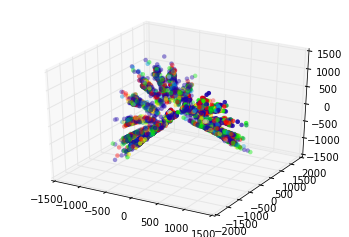

0.147200287733


In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D,proj3d
from matplotlib.figure import Figure
import numpy as np

pca = PCA(n_components=3)
pca.fit(data)
v_j  = pca.transform(data)

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
randomLCs = np.random.choice(range(len(files)), 5000, replace=False)
ax.scatter(v_j[randomLCs,0],v_j[randomLCs,1],v_j[randomLCs,2],c=clusterLabels[randomLCs],cmap='nipy_spectral',edgecolors='none')

plt.show()

print(sum(pca.explained_variance_ratio_))

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def reorganizeArray(X): 
    # This is just a transposition, could be accomplished by making X an np.array then transposing via X.T if prefered
    # TODO: Time the difference with large datasets (100,000+)
    return [[X[i][j] for i in range(len(X))] for j in range(len(X[0]))]
for n_feats in range(60):
    pca = PCA(n_components=n_feats)
    pca.fit(data)
    totalVarExp = sum(pca.explained_variance_ratio_)
    if totalVarExp>=.9:
        break

v_j  = pca.transform(data)


print("%s features to explain %s % of the variance"%(n_feats,100*sum(pca.explained_variance_ratio_)))

41 features to explain 90.3801347193 variance


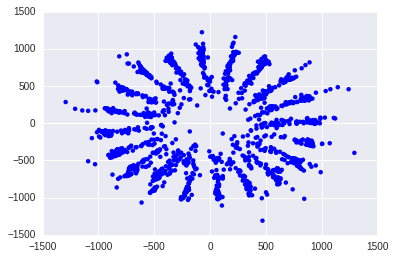

In [31]:
j=7
x=[v_j[i,0] for i in range(len(data)) if clusterLabels[i]==j]
y=[v_j[i,1] for i in range(len(data)) if clusterLabels[i]==j]
plt.scatter(x,y,c='b',edgecolors='none')


In [ ]:
from sklearn.manifold import Isomap

iso = Isomap(n_components=2,n_jobs=-1)
iso.fit(data)
data_new = iso.transform(data)

plt.scatter(data_new[:,0],data_new[:,1],c=clusterLabels,cmap='nipy_spectral',edgecolors='none')
plt.colorbar()

In [69]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
randInts = np.random.choice(range(len(files)), 10000, replace=False)
tsne_fit=tsne.fit_transform(data[randInts])

<IPython.core.display.Javascript object>


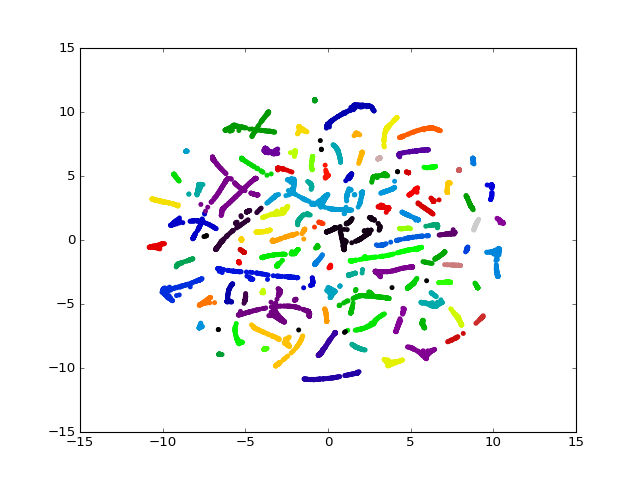

In [70]:
from sklearn.cluster import KMeans

def KMeans_clusters(data,nclusters):
    # Run KMeans, get clusters
    npdata = np.array(data)
    est = KMeans(n_clusters=nclusters)
    est.fit(npdata)
    clusters = est.labels_
    centers = est.cluster_centers_
    return clusters, centers

def DBSCAN_clusters(data,eps,min_points=None):
    npdata = np.array(data)
    if min_points==None:
        est = DBSCAN(eps=eps)
    else:
        est = DBSCAN(eps=eps,min_samples=min_points)
    
    est.fit(npdata)
    clusters = est.labels_
    coreSampleIndices = est.core_sample_indices_
    return clusters, coreSampleIndices

dataTSNE = [[tsne_fit[i][0],tsne_fit[i][1]] for i in range(len(tsne_fit))]
clusterLabels,coreSampleIndices = DBSCAN_clusters(dataTSNE,.5,5)
#clusterLabels,centers = KMeans_clusters(dataTSNE,60)
plt.scatter(tsne_fit[:,0],tsne_fit[:,1],c=clusterLabels,cmap='nipy_spectral',edgecolors='none')


<IPython.core.display.Javascript object>


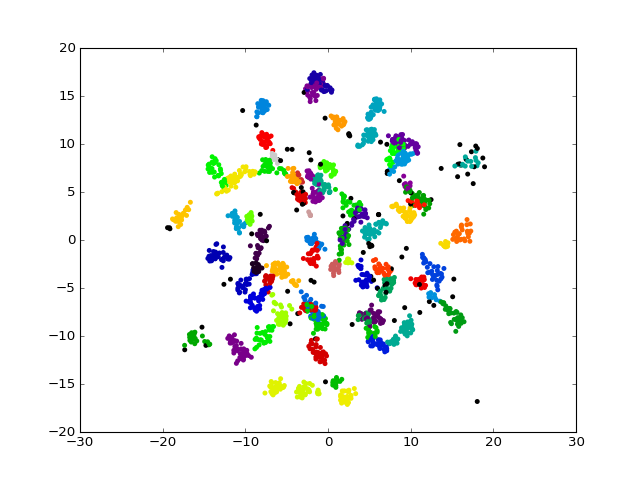

<IPython.core.display.Javascript object>


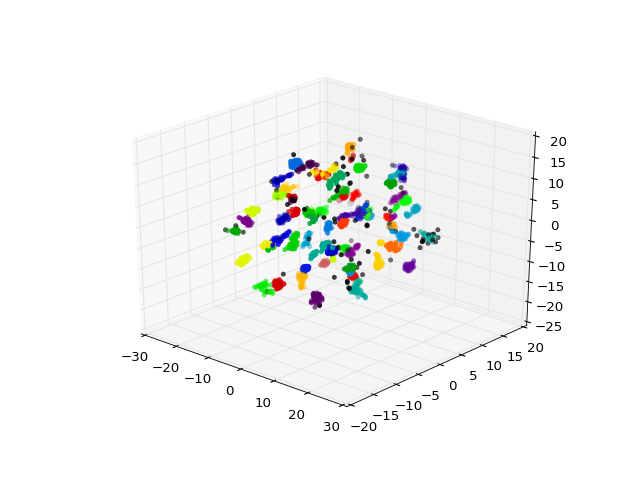

In [72]:
from sklearn.manifold import TSNE
%matplotlib notebook
tsne = TSNE(n_components=3)
randData = np.random.choice(range(len(files)), 2000, replace=False)
tsne_fit=tsne.fit_transform(data[randData])

def DBSCAN_clusters(data,eps,min_points=None):
    npdata = np.array(data)
    if min_points==None:
        est = DBSCAN(eps=eps)
    else:
        est = DBSCAN(eps=eps,min_samples=min_points)
    
    est.fit(npdata)
    clusters = est.labels_
    coreSampleIndices = est.core_sample_indices_
    return clusters, coreSampleIndices

dataTSNE = [[tsne_fit[i][0],tsne_fit[i][1],tsne_fit[i][2]] for i in range(len(tsne_fit))]
clusterLabels,coreSampleIndices = DBSCAN_clusters(dataTSNE,1,5)
#clusterLabels,centers = KMeans_clusters(dataTSNE,60)
plt.scatter(tsne_fit[:,0],tsne_fit[:,1],c=clusterLabels,cmap='nipy_spectral',edgecolors='none')

fig=plt.figure()
ax=fig.add_subplot(111,projection="3d")
ax.scatter(tsne_fit[:,0],tsne_fit[:,1],tsne_fit[:,2],c=clusterLabels,cmap='nipy_spectral',edgecolors='none')
plt.show()

In [74]:
print(max(clusterLabels))

69


#  3D density plots (Not working)

In [15]:
import numpy as np
from scipy import stats
from mayavi import mlab
import seaborn as sns
import multiprocessing
%matplotlib inline

sns.set_style("ticks")
def reorganizeArray(X): 
    # This is just a transposition, could be accomplished by making X an np.array then transposing via X.T if prefered
    # TODO: Time the difference with large datasets (100,000+)
    return [[X[i][j] for i in range(len(X))] for j in range(len(X[0]))]

ffeatures = reorganizeArray(plotArray[2])

def calc_kde(data):
    return kde(data.T)

x = np.array(ffeatures[30])
y = np.array(ffeatures[31])
z = np.array(ffeatures[25])

xyz = np.vstack([xexample,yexample,zexample])
kde = stats.gaussian_kde(xyz)

xmin, ymin, zmin = x.min(), y.min(), z.min()
xmax, ymax, zmax = x.max(), y.max(), z.max()
xi, yi, zi = np.mgrid[xmin:xmax:30j, ymin:ymax:30j, zmin:zmax:30j]
coords = np.vstack([item.ravel() for item in [xi, yi, zi]]) 

cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=cores)
results = pool.map(calc_kde, np.array_split(coords.T, 2))
density = np.concatenate(results).reshape(xi.shape)

figure = mlab.figure('DensityPlot')
grid = mlab.pipeline.scalar_field(xi, yi, zi, density)
min = density.min()
max=density.max()
mlab.pipeline.volume(grid, vmin=min, vmax=min + .5*(max-min))

pts = mlab.points3d(x, y, z, density, scale_mode='none', scale_factor=0.07) 
mask = pts.glyph.mask_points
mask.maximum_number_of_points = x.size
mask.on_ratio = 1
pts.glyph.mask_input_points = True

figure.scene.disable_render = False 

mlab.axes()
mlab.show()


ImportError: No module named mayavi

# DBSCAN Epsilon Estimation

In [7]:
"""
The suggested 'heuristic' from the original DBSCAN paper to determine a ballpark for epsilon.
Plots the distances from a center point (in this case we consider the center point of the clusters found through kmeans)
sorted by distance. The 'elbow' gives the cutoff between cluster points and noise/outliers.

I think this could just be applied directly to the kmeans clusters to determine the cutoff for each cluster. Though it's 
not obvious how to automate finding the bend.
"""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from sklearn.neighbors import NearestNeighbors

"""--- Importing the relevant data ---"""
identifier = raw_input('Enter the identifier of the data: ')
dataID = 'input/'+str(identifier)+'dataByLightCurve.npy'
data = np.load(dataID)

"""for f in outlierfiles:
    outlierIndices.append(files.index(f))"""

if __name__ == '__main__':
    # distance array containing all distances
    nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    distArr = distances[:,3]
    distArr.sort()
    pts = [i for i in range(len(distArr))]

    plt.scatter(pts, distArr)

    plt.show()


KeyboardInterrupt: 

In [ ]:
"""
DBSCAN Clustering and Plotting
Purpose: Find clusters and their outliers, output the results to np arrays and filelists
TODO: output to np arrays

Required:
.npy file produced from keplerml.py. Data should be organized by light curve (rather than feature)

This was created with the intent to cluster lightcurves based on the features calculated by keplerml.py. However,
the methodology used is general and can be applied to any set of data as long as the data is saved as a numpy array.
"""

import ast
import random
import numpy as np
np.set_printoptions(threshold='nan')
import scipy as sp
from scipy import stats
import pyfits
import math
# The order of the following is important, matplot.use('TkAgg') must be done before importing pyplot
import matplotlib
from mpl_toolkits.mplot3d import Axes3D,proj3d
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import sys
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk

root = Tk.Tk()
root.wm_title("Scatter")
import heapq
import scipy.signal
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from numpy.random import RandomState
from multiprocessing import Pool
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import RadioButtons
import os
import sys

identifier = raw_input('Enter the identifier of the data or type \'help\' for clarification: ')
if identifier == 'help':
    n_help = 1
    while(identifier == 'help'):
        if n_help == 2:
            print("\'help\' will be the assigned ID.")
        print(
        '''
        This will look for a numpy array (.npy) with the identifier as a prefix.
        If you haven\'t made the numpy array with keplerml.py, abort this with ctrl-c and run
        keplerml.py. If you have run keplerml.py, input the identifier you chose.
        
        If you would like to assign \'help\' as the ID, enter it again when prompted,
        this help text will not appear again.

        For example, if you chose \'ex\', there will be a .npy file 
        called exdataByLightCurve.npy that will be read in.
        For the identifier you would input \'ex\'
        ''')
        identifier = raw_input('Enter the identifier of the data: ')
        
        n_help += 1

# Transposition. Will change an array orgnaized by data point (coordinates) to an array organized 
# by feature (list of all values for each feature) and vice versa.
def reorganizeArray(X):
    return [[X[i][j] for i in range(len(X))] for j in range(len(X[0]))]

def DBSCAN_clusters(data,eps,min_points=None):
    npdata = np.array(data)
    if min_points==None:
        est = DBSCAN(eps=eps)
    else:
        est = DBSCAN(eps=eps,min_samples=min_points)
    
    est.fit(npdata)
    clusters = est.labels_
    coreSampleIndices = est.core_sample_indices_
    return clusters, coreSampleIndices

def seperatedClusters(data,nclusters,clusters):
    """
    Args:
    data - all data, organized by lightcurve 
    nclusters - number of clusters
    clusters - array of cluster labels
    
    Purpose: Create arrays dataByCluster and clusterIndexes containing data seperated by
    by cluster.
    """
    dataByCluster = []
    clusterIndexes = []
    
    # Will try to stick to the following:
    # cluster i, lightcurve j, feature k
    for i in range(nclusters):
        # Keeping track of which points get pulled into each cluster:
        clusterIndexes.append([j for j in range(len(data)) if clusters[j]==i])
        # Separating the clusters out into their own arrays (w/in the cluster array)
        dataByCluster.append([data[clusterIndexes[i][j]] for j in range(len(clusterIndexes[i]))])
        
        #Alternatively: (might have had some issues with the above, not sure...)
        #dataByCluster.append([])
        #for j in range(len(clusterIndexes[i])):
        #    dataByCluster[i].append(data[clusterIndexes[i][j]])
    return dataByCluster, clusterIndexes

def makeClusterFilelists(clusterIndexes,files):
    """
    returns: none
    Makes filelists seperated by cluster.
    
    Args:
    clusterIndexes - array containing n arrays each full of the indices of the 
    lightcurves for each cluster. The indices are the line number of the original
    file list.
    
    files - array containing the files in the original filelist in the order of the
    original file list.
    """

    for i in range(len(clusterIndexes)):
        outputfile = open('clusterOutput/DBSCANc%sfilelist'%i,'w')
        for j in range(len(clusterIndexes[i])):
            outputfile.write('%s\n'%files[clusterIndexes[i][j]]) 

def makeOutlierFilelists(allOutliers,files):
    """
    ARGS:
    allOutliers - array of indices of outlying points
    files - array of llc file names
    """
    ncluster=1
    for i in allOutliers:
        with open('clusterOutput/DBSCANoutlierfilelist','a') as outputfile:
            outputfile.write('%s\n'%files[i])
                
def makeClusterNpy(dataByCluster):
    n=1
    for i in dataByCluster:
        cluster = np.array(i)
        np.save('clusterOutput/DBSCANdataByLightCurve'%n,cluster)
        n+=1


# tkinter only works in main

if __name__ == '__main__':
    
    dataID = 'input/'+str(identifier)+'dataByLightCurve.npy'
    data = np.load(dataID)
    ffeatures=[[data[i][j] for i in range(len(data))] for j in range(len(data[0]))]
    filelist = 'input/'+str(identifier)+'filelist'
    files = [line.strip() for line in open(filelist)]

    clusterLabels,coreSampleIndices=DBSCAN_clusters(data,80)
    
    outlierInds = [i for i in range(len(clusterLabels))if clusterLabels[i]==-1]
    outlierFiles = [files[i] for i in outlierInds]
    
    nclusters = max(clusterLabels)+1
    
    dataByCluster,clusterIndexes=seperatedClusters(data,nclusters,clusterLabels)
    
    makeClusterFilelists(clusterIndexes,files)
    makeOutlierFilelists(outlierInds,files)
    """--- Organizing data and Labels ---"""
    
    ffeatures = reorganizeArray(data)

    # Betterlabels will contain the titles of axes we'll actually want on there
    listoffeatures = ['longtermtrend', 'meanmedrat', 'skews', 'varss', 'coeffvar', 'stds', 'numoutliers', 'numnegoutliers', 'numposoutliers', 'numout1s', 'kurt', 'mad', 'maxslope', 'minslope', 'meanpslope', 'meannslope', 'g_asymm', 'rough_g_asymm', 'diff_asymm', 'skewslope', 'varabsslope', 'varslope', 'meanabsslope', 'absmeansecder', 'num_pspikes', 'num_nspikes', 'num_psdspikes', 'num_nsdspikes','stdratio', 'pstrend', 'num_zcross', 'num_pm', 'len_nmax', 'len_nmin', 'mautocorrcoef', 'ptpslopes', 'periodicity', 'periodicityr', 'naiveperiod', 'maxvars', 'maxvarsr', 'oeratio', 'amp', 'normamp','mbp', 'mid20', 'mid35', 'mid50', 'mid65', 'mid80', 'percentamp', 'magratio', 'sautocorrcoef', 'autocorrcoef', 'flatmean', 'tflatmean', 'roundmean', 'troundmean', 'roundrat', 'flatrat']
    
    betterlabels = ['longtermtrend', 'meanmedrat', 'skews', 'varss', 'coeffvar', 'stds', 'numoutliers', 'numnegoutliers', 'numposoutliers', 'numout1s', 'kurt', 'mad', 'maxslope', 'minslope', 'meanpslope', 'meannslope', 'g_asymm', 'rough_g_asymm', 'diff_asymm', 'skewslope', 'varabsslope', 'varslope', 'meanabsslope', 'absmeansecder', 'num_pspikes', 'Number of Negative Spikes (Slope > 3*sigma)', 'num_psdspikes', 'num_nsdspikes','stdratio', 'pstrend', 'Number of Longterm Trendline Crossings', 'Number of Peaks', 'len_nmax', 'len_nmin', 'mautocorrcoef', 'ptpslopes', 'periodicity', 'periodicityr', 'naiveperiod', 'maxvars', 'maxvarsr', 'oeratio', 'amp', 'normamp','mbp', 'mid20', 'mid35', 'mid50', 'mid65', 'mid80', 'percentamp', 'magratio', 'sautocorrcoef', 'autocorrcoef', 'flatmean', 'tflatmean', 'roundmean', 'troundmean', 'roundrat', 'flatrat']
    
    # labellist keeps track of what each axis should be labelled
    # initialized with some interesting axes (based on past experience)
    labellist=[betterlabels[30],betterlabels[31],betterlabels[25]]
    
    # axesdict could probably be accomoplished with a list, see the new list currentData,
    # I'm partial to the dictionary because it helps me keep things associated directly.
    
    axesdict = {'xaxis':ffeatures[30],'yaxis':ffeatures[31],'zaxis':ffeatures[25]}
    fig = Figure()
    
    # a tk.DrawingArea
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)
    
    # empty subplot for scattered data
    ax = fig.add_subplot(111, projection='3d')
    
    # tk text input boxes
    e1 = Tk.Entry(master=root)
    e1.insert(0,'30')
    e1.pack(side=Tk.LEFT)
    e2 = Tk.Entry(master=root)
    e2.insert(0,'31')
    e2.pack(side=Tk.LEFT)
    e3 = Tk.Entry(master=root)
    e3.insert(0,'25')
    e3.pack(side=Tk.LEFT)
    
    def redraw():
        # Clear the existing plots (if any)
        ax.cla()
        # Get the new axes from the text input boxes
        axis1 = int(e1.get())
        axis2 = int(e2.get())
        axis3 = int(e3.get())
        # Get the data for the axes, assign data to the right axes
        axesdict['xaxis'] = ffeatures[axis1]
        axesdict['yaxis'] = ffeatures[axis2]
        axesdict['zaxis'] = ffeatures[axis3]
        # Get and assign labels to their axes
        labellist[0] = betterlabels[axis1]
        labellist[1] = betterlabels[axis2]
        labellist[2] = betterlabels[axis3]
        # Set those labels
        ax.set_xlabel(labellist[0])
        ax.set_ylabel(labellist[1])
        ax.set_zlabel(labellist[2])
        # Scatter the data
        ax.scatter(axesdict['xaxis'], axesdict['yaxis'], axesdict['zaxis'],c=clusterLabels.astype(np.float))
        
        canvas.draw()

    redraw() # First draw
    canvas.show()
    
    b1 = Tk.Button(master=root, text='Plot',command=redraw)
    b1.pack(side=Tk.LEFT)
    
root.mainloop()

# Random Filelist

In [ ]:
"""
Purpose: Given a filelist this will generate a randomized filelist.
User must input the number of sources they would like, and the path to the
filelist from which they want to draw.
This will generate a filelist named 'randomFilelist', will overwrite any previous random filelists
by the same name.
"""

import numpy as np
if sys.version_info[0] < 3:
    from Tkinter import Tk
else:
    from tkinter import Tk
from tkFileDialog import askopenfilename

print('Select the filelist')
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filelist = askopenfilename() # show an "Open" dialog box and return the path to the selected file

NumLCs = raw_input('How many sources? ')

files = [line.strip() for line in open(filelist)]

randomLCs = np.random.choice(files, NumLCs, replace=False)

# test if Tabby star is included in the otherwise random set, insert if not
import fnmatch

tabbyCheck = fnmatch.filter(randomLCs, '*8462852*')
tabby = fnmatch.filter(files,'*8462852*')

if tabbyCheck==[]:
    randomLCs = np.delete(randomLCs,0)
    randomLCs = np.insert(randomLCs,0,tabby)
    
# output random filelist to randomFilelist
for i in range(len(randomLCs)):
    outputfile = open('randomFilelist','w')
    outputfile.write('%s\n'%randomLCs[i]) 